In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [107]:
# === Load COE Data ===
coe_df = pd.read_csv("COEBiddingResultsPrices.csv")

# === Load CPI Data ===
cpi_df = pd.read_csv("ConsumerPriceIndexCPI2019AsBaseYearMonthlySeasonallyAdjusted.csv")

# === Bank Interest Rates ===
banks_interest_rates = pd.read_csv("CurrentBanksInterestRatesEndOfPeriodMonthly.csv")


In [108]:
coe_df['month'] = pd.to_datetime(coe_df['month'], format='%Y-%m')


In [109]:
cpi_df_cleaned = cpi_df.dropna(how='all', subset=cpi_df.columns[1:])

cpi_melted = []
for _, row in cpi_df_cleaned.iterrows():
    series_name = row['DataSeries'].strip()
    for col in cpi_df_cleaned.columns[1:]:  # Skip 'DataSeries' column
        try:
            date = pd.to_datetime(col, format='%Y%b')
        except:
            continue
        value = pd.to_numeric(row[col], errors='coerce')
        if pd.notna(date) and pd.notna(value):
            cpi_melted.append({'DataSeries': series_name, 'month': date, 'value': value})

cpi_long_df = pd.DataFrame(cpi_melted)

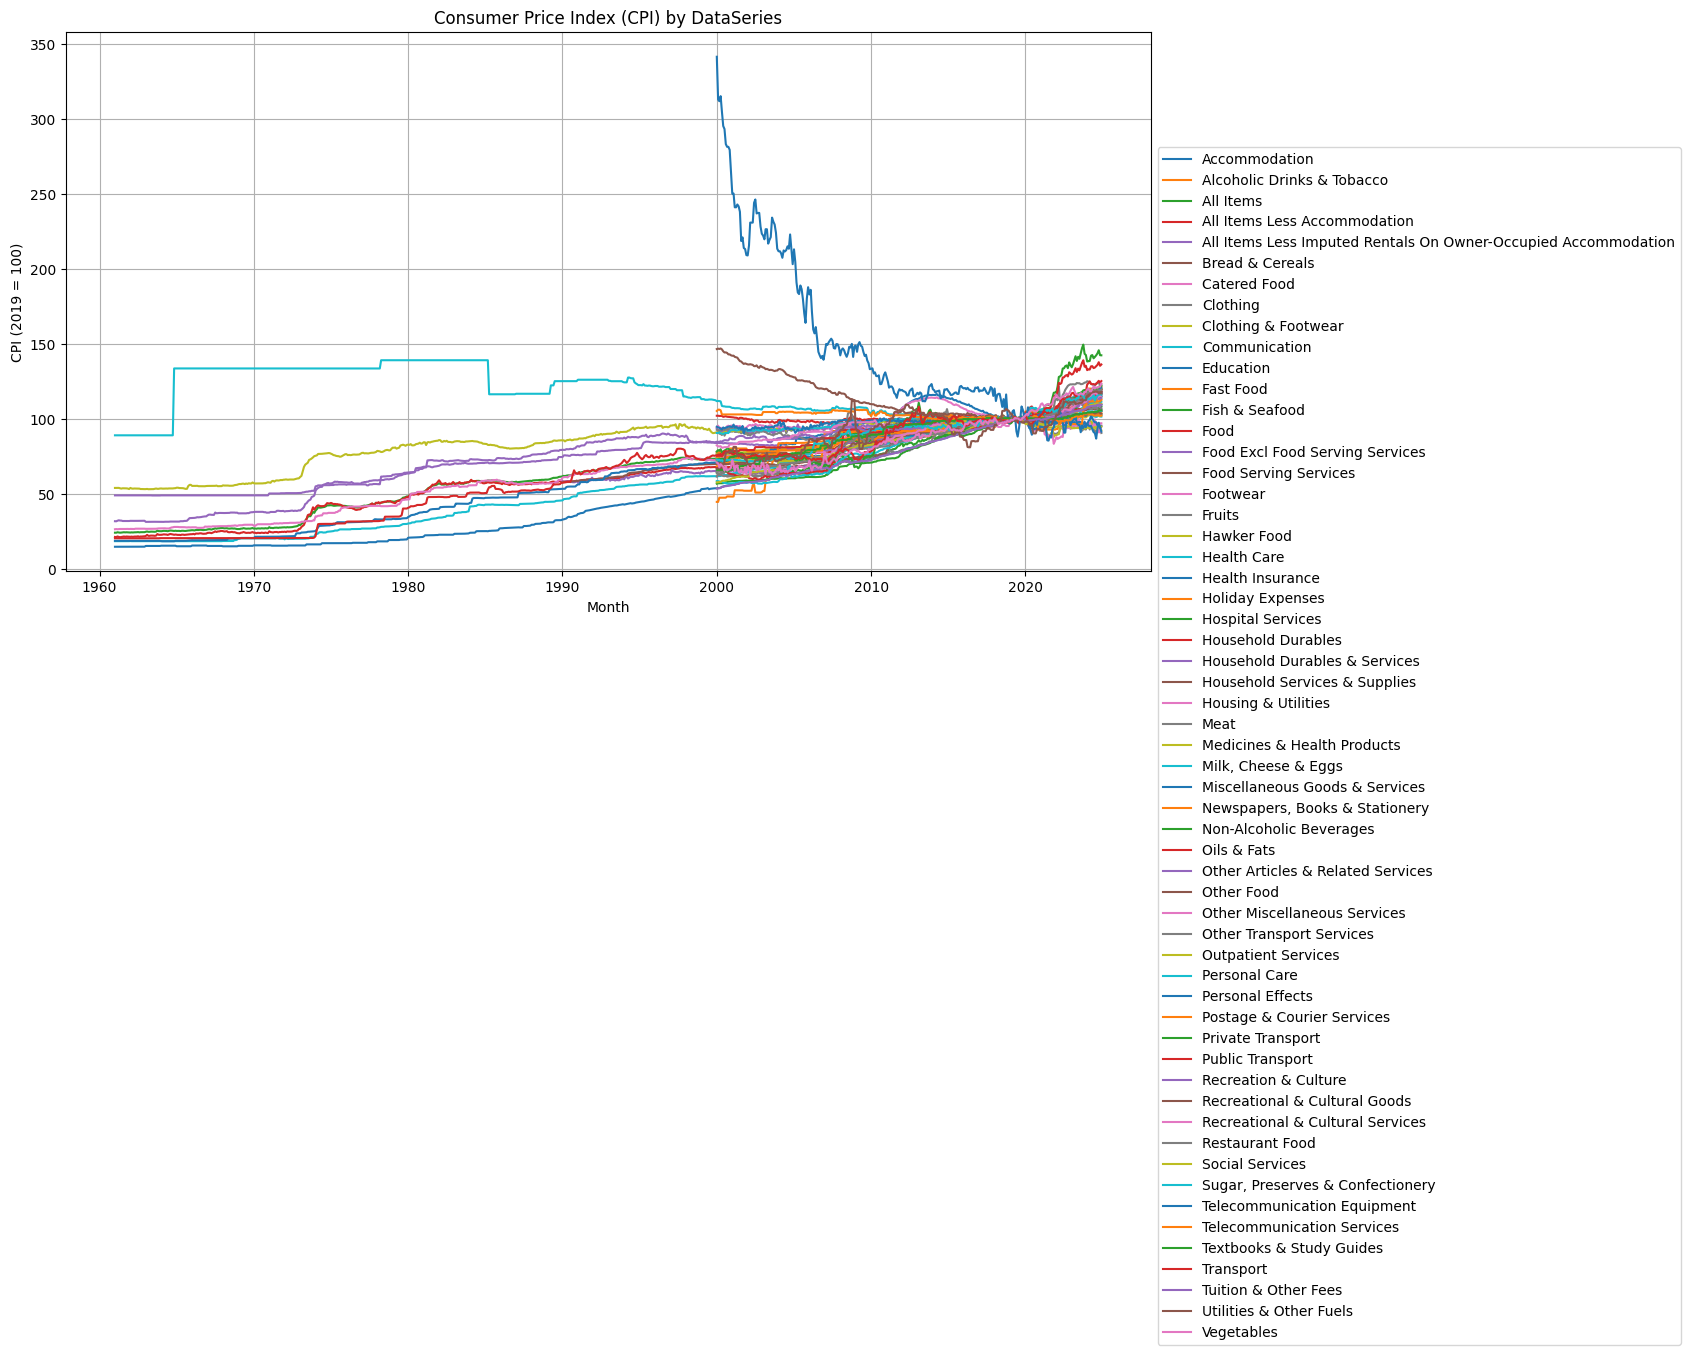

In [110]:
plt.figure(figsize=(14,7))
for name, group in cpi_long_df.groupby('DataSeries'):
    plt.plot(group['month'], group['value'], label=name)

plt.title("Consumer Price Index (CPI) by DataSeries")
plt.xlabel("Month")
plt.ylabel("CPI (2019 = 100)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8))
plt.grid(True)
plt.show()

In [111]:
# Filter for "All Items" CPI only
cpi_all_items = cpi_df[cpi_df['DataSeries'].str.strip() == 'All Items']

# Drop "DataSeries" column and transpose
cpi_all_items = cpi_all_items.drop(columns=['DataSeries']).T.reset_index()
cpi_all_items.columns = ['month_str', 'cpi_all_items']
cpi_all_items['month'] = pd.to_datetime(cpi_all_items['month_str'], format='%Y%b', errors='coerce')
cpi_all_items.dropna(subset=['month'], inplace=True)
cpi_all_items = cpi_all_items[['month', 'cpi_all_items']]

In [112]:
melted_list = []

for _, row in banks_interest_rates.iterrows():
    series_name = row['DataSeries'].strip()
    for col in banks_interest_rates.columns[1:]:  # Skip 'DataSeries' column
        try:
            date = pd.to_datetime(col, format='%Y%b')
        except:
            continue  # skip malformed date columns
        value = pd.to_numeric(row[col], errors='coerce')
        if pd.notna(date) and pd.notna(value):
            melted_list.append({'DataSeries': series_name, 'month': date, 'value': value})

long_df = pd.DataFrame(melted_list)

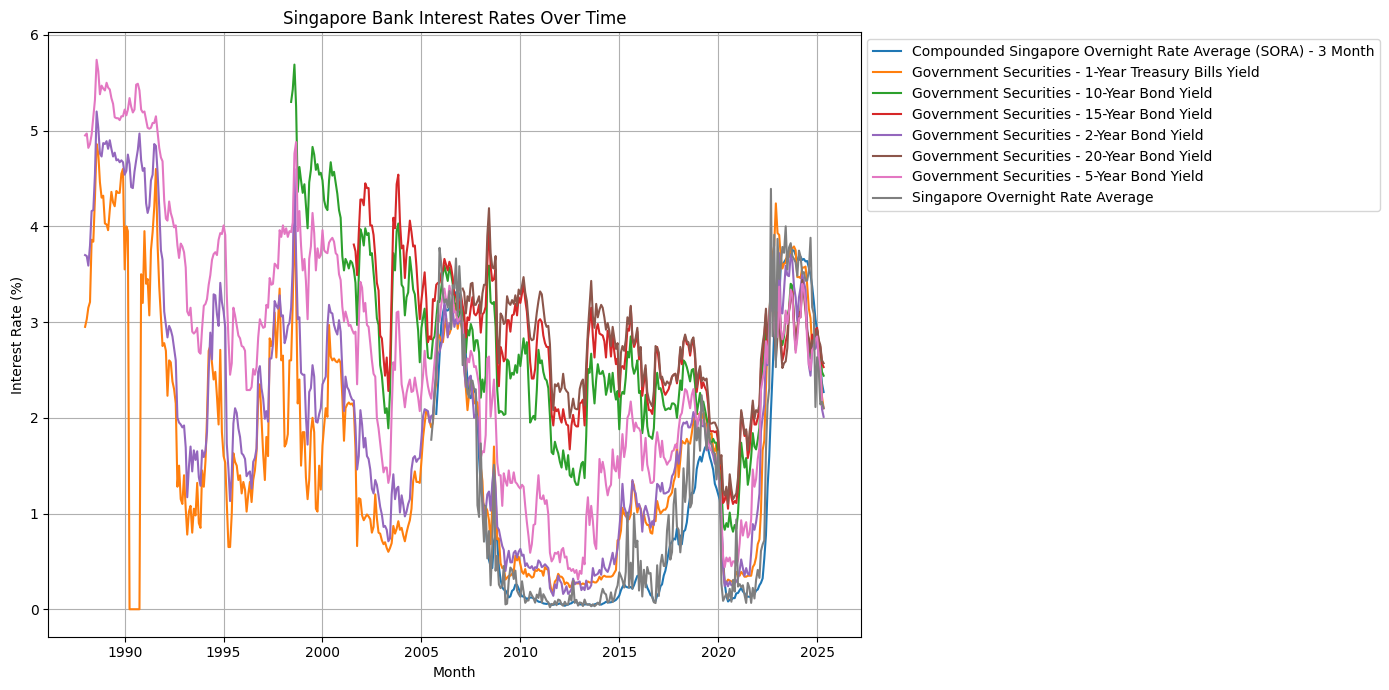

In [113]:
plt.figure(figsize=(14, 7))
for name, group in long_df.groupby('DataSeries'):
    plt.plot(group['month'], group['value'], label=name)

plt.title("Singapore Bank Interest Rates Over Time")
plt.xlabel("Month")
plt.ylabel("Interest Rate (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
sora = banks_interest_rates[banks_interest_rates['DataSeries'].str.strip() == 'Singapore Overnight Rate Average']

# Drop "DataSeries" column and transpose
sora = sora.drop(columns=['DataSeries']).T.reset_index()
sora.columns = ['month_str', 'sora']
sora['month'] = pd.to_datetime(sora['month_str'], format='%Y%b', errors='coerce')
sora.dropna(subset=['month'], inplace=True)
sora = sora[['month', 'sora']]

In [115]:
merged_df = coe_df.copy()
merged_df = merged_df.merge(cpi_all_items, on='month', how='left')
merged_df = merged_df.merge(sora, on='month', how='left')

clean_df = merged_df.dropna()

# === Preview Result ===
print(clean_df)

          month  bidding_no vehicle_class  quota bids_success bids_received  \
0    2010-01-01           1    Category A   1152         1145          1342   
1    2010-01-01           1    Category B    687          679           883   
2    2010-01-01           1    Category C    173          173           265   
3    2010-01-01           1    Category D    373          365           509   
4    2010-01-01           1    Category E    586          567          1011   
...         ...         ...           ...    ...          ...           ...   
1765 2024-12-01           2    Category A   1035          998         1,506   
1766 2024-12-01           2    Category B    676          667           987   
1767 2024-12-01           2    Category C    255          255           400   
1768 2024-12-01           2    Category D    519          504           641   
1769 2024-12-01           2    Category E    182          170           330   

      premium cpi_all_items    sora  
0       18502

In [116]:
correlation = clean_df[['premium', 'cpi_all_items', 'sora']].corr()
print(correlation)

                premium  cpi_all_items      sora
premium        1.000000       0.430668  0.327364
cpi_all_items  0.430668       1.000000  0.820446
sora           0.327364       0.820446  1.000000


In [117]:
clean_df = merged_df.dropna().copy()

clean_df['premium'] = pd.to_numeric(clean_df['premium'], errors='coerce')
clean_df['cpi_all_items'] = pd.to_numeric(clean_df['cpi_all_items'], errors='coerce')
clean_df['sora'] = pd.to_numeric(clean_df['sora'], errors='coerce')


In [118]:
X = clean_df[['cpi_all_items', 'sora']]
y = clean_df['premium']
X = sm.add_constant(X)  # Adds intercept

# Fit regression model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                premium   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     203.9
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           2.04e-80
Time:                        15:09:26   Log-Likelihood:                -20653.
No. Observations:                1770   AIC:                         4.131e+04
Df Residuals:                    1767   BIC:                         4.133e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.646e+05   1.56e+04    -10.558

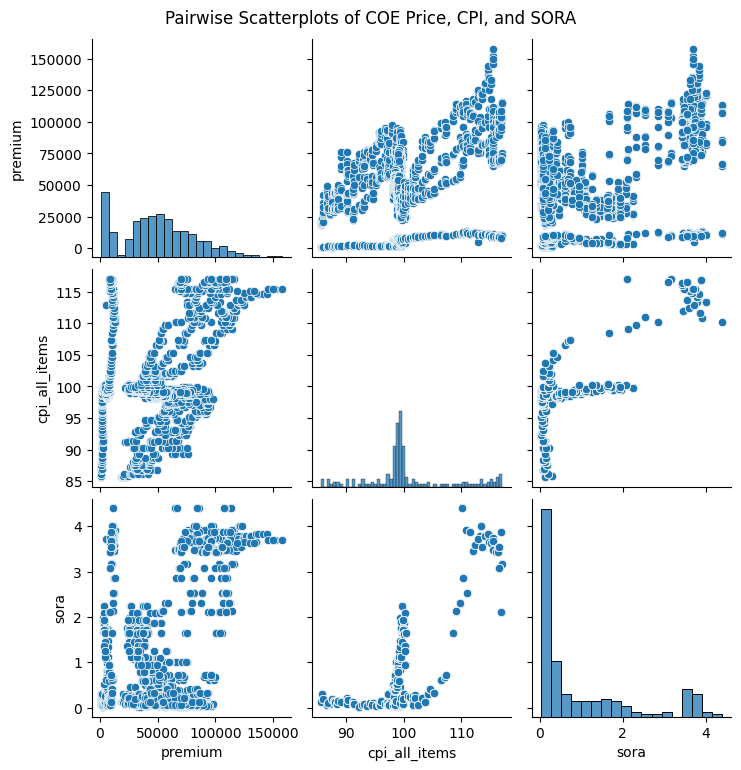

In [119]:
sns.pairplot(clean_df, vars=['premium', 'cpi_all_items', 'sora'])
plt.suptitle("Pairwise Scatterplots of COE Price, CPI, and SORA", y=1.02)
plt.show()


In [120]:
# Select relevant columns
features = clean_df[['premium', 'cpi_all_items', 'sora']]

# Apply standard scaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(features)

# Create standardized DataFrame
scaled_df = clean_df.copy()
scaled_df[['premium_z', 'cpi_z', 'sora_z']] = scaled_values


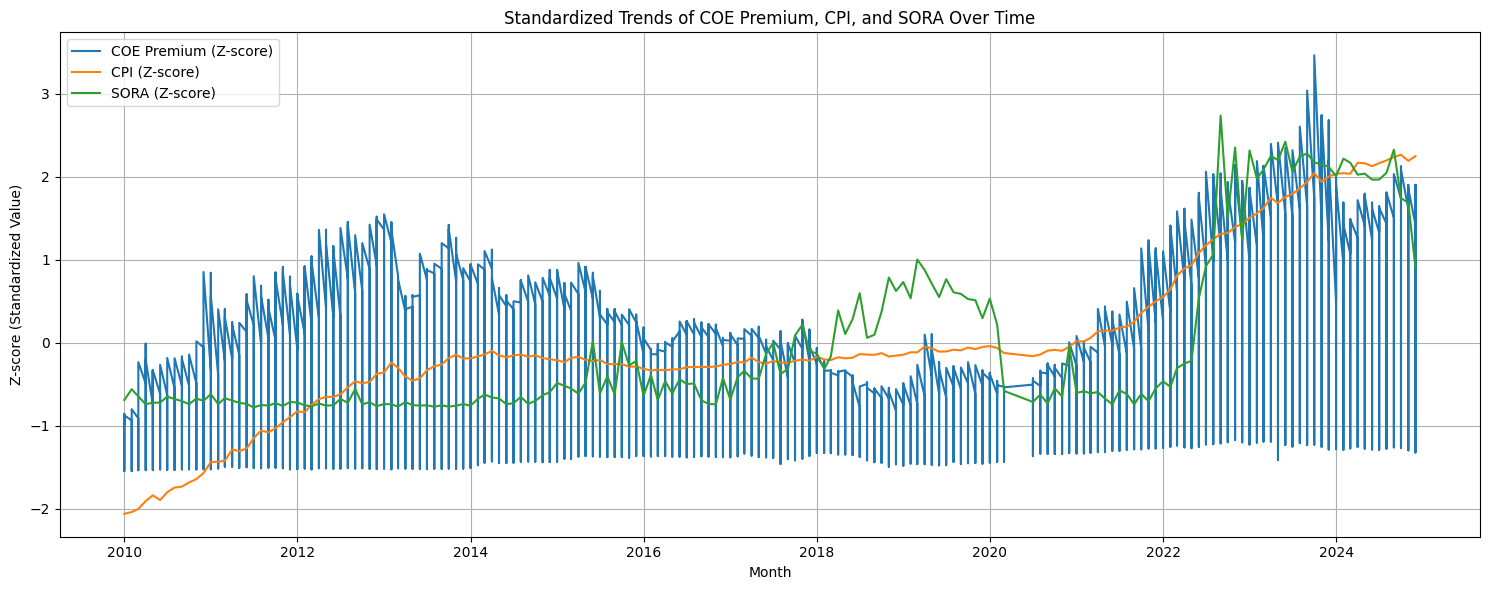

In [121]:
# Ensure 'scaled_df' has the standardized columns: 'premium_z', 'cpi_z', 'sora_z'

plt.figure(figsize=(15, 6))
plt.plot(scaled_df['month'], scaled_df['premium_z'], label='COE Premium (Z-score)')
plt.plot(scaled_df['month'], scaled_df['cpi_z'], label='CPI (Z-score)')
plt.plot(scaled_df['month'], scaled_df['sora_z'], label='SORA (Z-score)')

plt.title('Standardized Trends of COE Premium, CPI, and SORA Over Time')
plt.xlabel('Month')
plt.ylabel('Z-score (Standardized Value)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


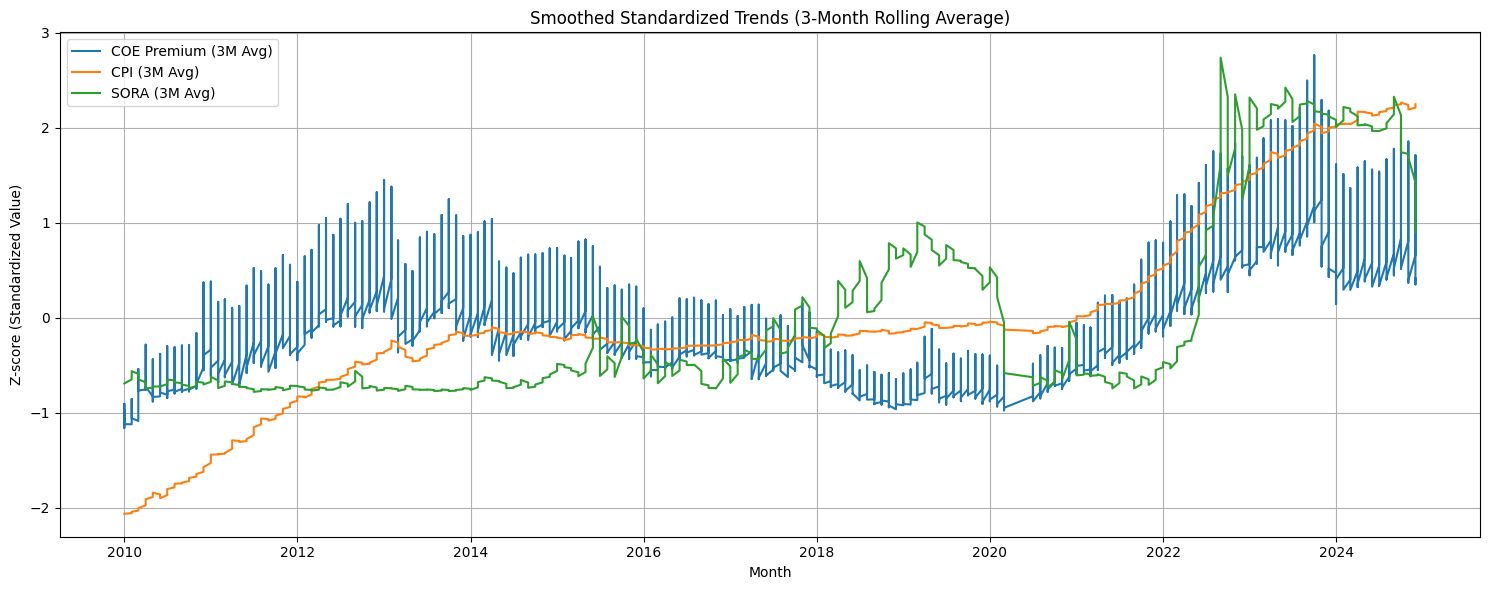

In [122]:
# Add 3-month rolling averages (optional smoothing)
scaled_df['premium_z_roll'] = scaled_df['premium_z'].rolling(window=3).mean()
scaled_df['cpi_z_roll'] = scaled_df['cpi_z'].rolling(window=3).mean()
scaled_df['sora_z_roll'] = scaled_df['sora_z'].rolling(window=3).mean()

plt.figure(figsize=(15, 6))
plt.plot(scaled_df['month'], scaled_df['premium_z_roll'], label='COE Premium (3M Avg)')
plt.plot(scaled_df['month'], scaled_df['cpi_z_roll'], label='CPI (3M Avg)')
plt.plot(scaled_df['month'], scaled_df['sora_z_roll'], label='SORA (3M Avg)')

plt.title('Smoothed Standardized Trends (3-Month Rolling Average)')
plt.xlabel('Month')
plt.ylabel('Z-score (Standardized Value)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [123]:
# Define X and y
X_cpi = clean_df[['cpi_all_items']]
y = clean_df['premium']

# Add constant term
X_cpi = sm.add_constant(X_cpi)

# Fit the model
model_cpi = sm.OLS(y, X_cpi).fit()
print(model_cpi.summary())


                            OLS Regression Results                            
Dep. Variable:                premium   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     402.6
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           7.63e-81
Time:                        15:09:27   Log-Likelihood:                -20656.
No. Observations:                1770   AIC:                         4.132e+04
Df Residuals:                    1768   BIC:                         4.133e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.382e+05   9375.583    -14.743

In [124]:
# Define X and y
X_sora = clean_df[['sora']]
y = clean_df['premium']

# Add constant term
X_sora = sm.add_constant(X_sora)

# Fit the model
model_sora = sm.OLS(y, X_sora).fit()
print(model_sora.summary())


                            OLS Regression Results                            
Dep. Variable:                premium   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     212.2
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           1.74e-45
Time:                        15:09:27   Log-Likelihood:                -20737.
No. Observations:                1770   AIC:                         4.148e+04
Df Residuals:                    1768   BIC:                         4.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.122e+04    901.553     45.725      0.0

In [125]:

# Define predictors and target
X = clean_df[['cpi_all_items', 'sora']]
y = clean_df['premium']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

print("Ridge Coefficients:", ridge_model.coef_)
print("R^2 score (test set):", ridge_model.score(X_test, y_test))


Ridge Coefficients: [15672.9608097  -2913.35229688]
R^2 score (test set): 0.19636892236815595


In [126]:

# Lasso regression
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

print("Lasso Coefficients:", lasso_model.coef_)
print("R^2 score (test set):", lasso_model.score(X_test, y_test))


Lasso Coefficients: [15710.56953806 -2946.20767182]
R^2 score (test set): 0.19634289639164826


In [127]:
# Drop any rows that contain non-numeric values
X_clean = X.apply(pd.to_numeric, errors='coerce').dropna()


vif_df = pd.DataFrame()
vif_df["feature"] = X_clean.columns
vif_df["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(X_clean.shape[1])]
print(vif_df)



         feature       VIF
0  cpi_all_items  1.805614
1           sora  1.805614
